## dataset

In [1]:
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image

import numpy as np
import re
import glob

Using TensorFlow backend.


In [2]:
data_type = {0:'nv', 1:'mel', 2:'bcc'}
img_dir = './dataset/img'

In [3]:
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_aug_path(data_type:str, img_dir:str):
    path = f"{img_dir}/resize_img/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

def img_array(data_type:str, img_dir:str, data_num:int):
    img_array = np.zeros((data_num, 75, 100))
    img_path = get_aug_path(data_type, img_dir)
    for i in range(data_num):
        img_array[i] += np.array(((Image.open(img_path[i])).convert('L')))
    img_train, img_test = train_test_split(img_array, train_size= 0.85)
    return img_train, img_test

# def dataset(dataset:int, data1:list, data2:list, data3:list):
#     datasets = {0:7401, 1:1851}
#     data = {0:data1, 1:data2, 2:data3}
#     x = np.zeros((datasets[dataset]*3, 45, 60, 3))
#     for num in range(3):
#         data_num = data[num]
#         for i in range(datasets[dataset]):
#             x[(num*datasets[dataset])+i] += data_num[i]
#     return x

def dataset(dataset:int, data1:list, data2:list, data3:list):
    datasets = {0:436, 1:78}
    data = {0:data1, 1:data2, 2:data3}
    x = np.zeros((datasets[dataset]*3, 75, 100))
    for i in range(datasets[dataset]):
        for num in range(3):
            data_num = data[num][i]
            x[(3*i)+num] += data_num
    return x

def plot_history_lost(hist):
    plt.plot(hist.history['loss'], label='loss for training')
    plt.plot(hist.history['val_loss'], label='loss for validation')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()
    
def plot_history_acc(hist):
    plt.plot(hist.history['acc'], label='accuracy for validation')
    plt.plot(hist.history['val_acc'], label='accuracy for validation')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acuuracy')
    plt.ylim([0,1])
    plt.show()

In [4]:
int(514*0.85)

436

In [5]:
int(514*0.15)

77

In [6]:
nv_train, nv_test = img_array(data_type[0], img_dir, 514)
mel_train, mel_test = img_array(data_type[1], img_dir, 514)
bcc_train, bcc_test = img_array(data_type[2], img_dir, 514)

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
nv_test.shape[0]

78

In [11]:
_x_train = dataset(0, nv_train, mel_train, bcc_train)
_x_train = _x_train.reshape((_x_train.shape[0],75,100,1))
_x_test = dataset(1, nv_test, mel_test, bcc_test)
_x_test = _x_test.reshape((_x_test.shape[0],75,100,1))
_y_train = np.array([0, 1, 2]*nv_train.shape[0])
_y_test = np.array([0, 1, 2]*nv_test.shape[0])
# _y_train = np.repeat([0, 1, 2], 7401)
# _y_test = np.repeat([0, 1, 2], 1851)

# _x_train /= 255.0
# _x_test /= 255.0

# _x_train = _x_train.astype('float32')
# _x_test = _x_test.astype('float32')

x_train_mean = np.mean(_x_train)
x_test_mean = np.mean(_x_test)
x_train_std = np.std(_x_train)
x_test_std = np.std(_x_test)

x_train = (_x_train - x_train_mean)/x_train_std
x_test = (_x_test - x_test_mean)/x_test_std

# x_train = _x_train
# x_test = _x_test

# x_train = _x_train / 255.0
# x_test = _x_test / 255.0
y_train = to_categorical(_y_train)
y_test = to_categorical(_y_test)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [12]:
X = x_train
Y = y_train

# define X-fold cross validation
kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
cvscores = []

NameError: name 'StratifiedKFold' is not defined

In [12]:
print(f'''
Dataset shape
x_train: {x_train.shape} |-> y_train: {y_train.shape},
x_test: {x_test.shape} |-> y_test: {y_test.shape},
x_validate: {x_validate.shape} |-> y_validate: {y_validate.shape}''')


Dataset shape
x_train: (1177, 75, 100, 1) |-> y_train: (1177, 3),
x_test: (234, 75, 100, 1) |-> y_test: (234, 3),
x_validate: (131, 75, 100, 1) |-> y_validate: (131, 3)


## CNN

In [13]:
0.85*0.9

0.765

In [14]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import rmsprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
import random
import matplotlib.pyplot as plt
from termcolor import colored

In [15]:
batch_size = 512
num_classes = 3
epochs = 100
fold_num = 5
seed = 7
np.random.seed(seed)

In [65]:
model = Sequential()
model.add(Conv2D(32, (4,4), padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (4,4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
          optimizer=rmsprop(),
          metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
# Fit the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[es])


# Evaluate
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/50
1177/1177 [==============================] - 1s 1ms/step - loss: 4.6924 - acc: 0.3891
Epoch 2/50
 512/1177 [============>.................] - ETA: 0s - loss: 6.3678 - acc: 0.5625

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1177/1177 [==============================] - 0s 336us/step - loss: 6.7570 - acc: 0.5395
Epoch 3/50
1177/1177 [==============================] - 0s 307us/step - loss: 5.6938 - acc: 0.6032
Epoch 4/50
1177/1177 [==============================] - 0s 308us/step - loss: 5.3318 - acc: 0.5837
Epoch 5/50
1177/1177 [==============================] - 0s 339us/step - loss: 4.2253 - acc: 0.4851
Epoch 6/50
1177/1177 [==============================] - 0s 309us/step - loss: 1.5319 - acc: 0.5854
Epoch 7/50
1177/1177 [==============================] - 0s 311us/step - loss: 0.8203 - acc: 0.6746
Epoch 8/50
1177/1177 [==============================] - 0s 311us/step - loss: 0.7282 - acc: 0.6975
Epoch 9/50
1177/1177 [==============================] - 0s 311us/step - loss: 0.7007 - acc: 0.6950
Epoch 10/50
1177/1177 [==============================] - 0s 335us/step - loss: 0.6978 - acc: 0.7171
Epoch 11/50
1177/1177 [==============================] - 0s 337us/step - loss: 0.6791 - acc: 0.7264
Epoch 12/50
1177/11

In [16]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (4,4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
# model = Sequential()
# model.add(Conv2D(12, (3,4), padding='same', input_shape=x_train.shape[1:]))
# model.add(Conv2D(12, (3,4), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
# # model.add(Dropout(0.2))

# # model.add(Conv2D(16, (4,4), padding='same'))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D((2,2)))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.2))

# # model.add(Conv2D(48, (3,4), padding='same'))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D((2,2)))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(48))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

# es = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
# # opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# opt = keras.optimizers.rmsprop()
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [18]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es])

model.save('nv_cancer_cnn_raw_large_gray5.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1177 samples, validate on 234 samples
Epoch 1/100
1177/1177 [==============================] - 4s 3ms/step - loss: 5.1645 - acc: 0.3161 - val_loss: 1.0904 - val_acc: 0.4060
Epoch 2/100
1177/1177 [==============================] - 0s 315us/step - loss: 1.1089 - acc: 0.4435 - val_loss: 1.1071 - val_acc: 0.4573
Epoch 3/100
1177/1177 [==============================] - 0s 319us/step - loss: 1.0497 - acc: 0.4936 - val_loss: 0.9129 - val_acc: 0.6453
Epoch 4/100
1177/1177 [==============================] - 0s 319us/step - loss: 0.8831 - acc: 0.6075 - val_loss: 1.3617 - val_acc: 0.4658
Epoch 5/100
1177/1177 [==============================] - 0s 319us/step - loss: 1.2074 - acc: 0.5225 - val_loss: 0.8543 - val_acc: 0.6453
Epoch 6/100
1177/1177 [==============================] - 0s 322us/step - loss: 0.8484 - acc: 0.6202 - val_loss: 0.7841 - val_acc: 0.6624
Epoch 7/100
1177/1177 [==============================] - 0s 322us/step - loss: 0.8208 - acc: 0.6534 - val_loss: 0.7712 - val_acc: 0.6

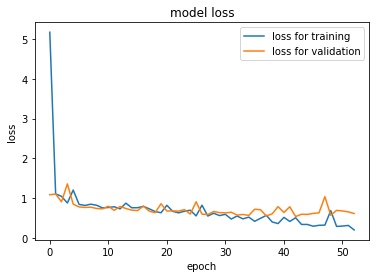

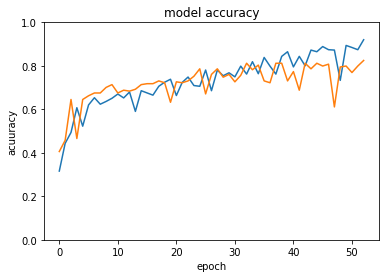

In [19]:
plot_history_lost(history)
plot_history_acc(history)

In [25]:
model = load_model('nv_cancer_cnn_raw_large_gray4.h5')

In [21]:
len(y_validate)

131

In [26]:
nv_cancer_labels = np.array([
    'nv',
    'mel',
    'bcc'
])

right = 0
mistake = 0

for j in range(30):
    index = np.zeros(100)
    for i in range(100):
        index[i] += random.randint(0,x_validate.shape[0]-1)

    for i in range(100):
        num = int(index[i])
        image = x_validate[num]
        for k in [0,1,2]:
            if y_validate[num][k] == 1:
                ans = k
        data = x_validate[num].reshape((1, 75, 100, 1))

        pred = model.predict(data, batch_size=64)
        bestnum  = 0.0
        bestclass = 0
        for n in [0,1,2]:
            if bestnum < pred[0][n]:
                bestnum = pred[0][n]
                bestclass = n

        if bestclass == ans:
            right += 1
        else:
            mistake += 1
        
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

The number of correct answers:  2540
The number of mistakes:  460
A correct answer rate:  84.66666666666667 %


In [27]:
model.predict(x_validate[0].reshape((1, 75, 100, 1)))[0]

array([6.1779497e-06, 1.4967333e-03, 9.9849713e-01], dtype=float32)

In [28]:
im = np.array((Image.open('./dataset/bcc0_1.jpg')).convert('L'))

In [29]:
img = (im - np.mean(im))/np.std(im)
# img = (im - x_test_mean) / x_test_std
data1 = img.reshape((1, 75, 100, 1))
pred = model.predict(data1)
bestnum  = 0.0
bestclass = 0
for n in [0,1,2]:
    if bestnum < pred[0][n]:
        bestnum = pred[0][n]
        bestclass = n
print(bestclass)

2


In [30]:
print(pred[0][0])
print(pred[0][1])
print(pred[0][2])

2.5616252e-14
4.9539843e-13
1.0


In [32]:
sample_files = glob.glob('./dataset/img/sample/all/*')
cancer_labels = {0:'nv', 1:'mel', 2:'bcc'}

right = 0
wrong = 0
for sample_file in sample_files:
    sample_img = np.array((Image.open(sample_file)).convert('L'))
#     sample_img = np.array((Image.open(sample_file)))
    norm_img = (sample_img - np.mean(sample_img))/np.std(sample_img)
    sample_data = norm_img.reshape((1, 75, 100, 1))
    pred = model.predict(sample_data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    if sample_file[25:26] == 'n':
        ans = 0
    elif sample_file[25:26] == 'm':
        ans = 1
    else:
        ans = 2
    if ans == bestclass:
        print(f'{sample_file[25:]}:{cancer_labels[bestclass]}')
        right += 1
    else:
        print(colored(f'{sample_file[25:]}:{cancer_labels[bestclass]}', 'red'))
        wrong += 1
acc = right / (right + wrong) * 100
print(f'acc:{acc}%')

In [89]:
import pandas as pd
sample_graph = [['nv', '-', 7, 3],['mel', 5, '-', 2],['bcc', 1, 2, '-']]
sample_df = pd.DataFrame(sample_graph, columns=['bestclass', 'nv', 'mel', 'bcc'])

In [90]:
sample_df

,bestclass,nv,mel,bcc
0,nv,-,7,3
1,mel,5,-,2
2,bcc,1,2,-


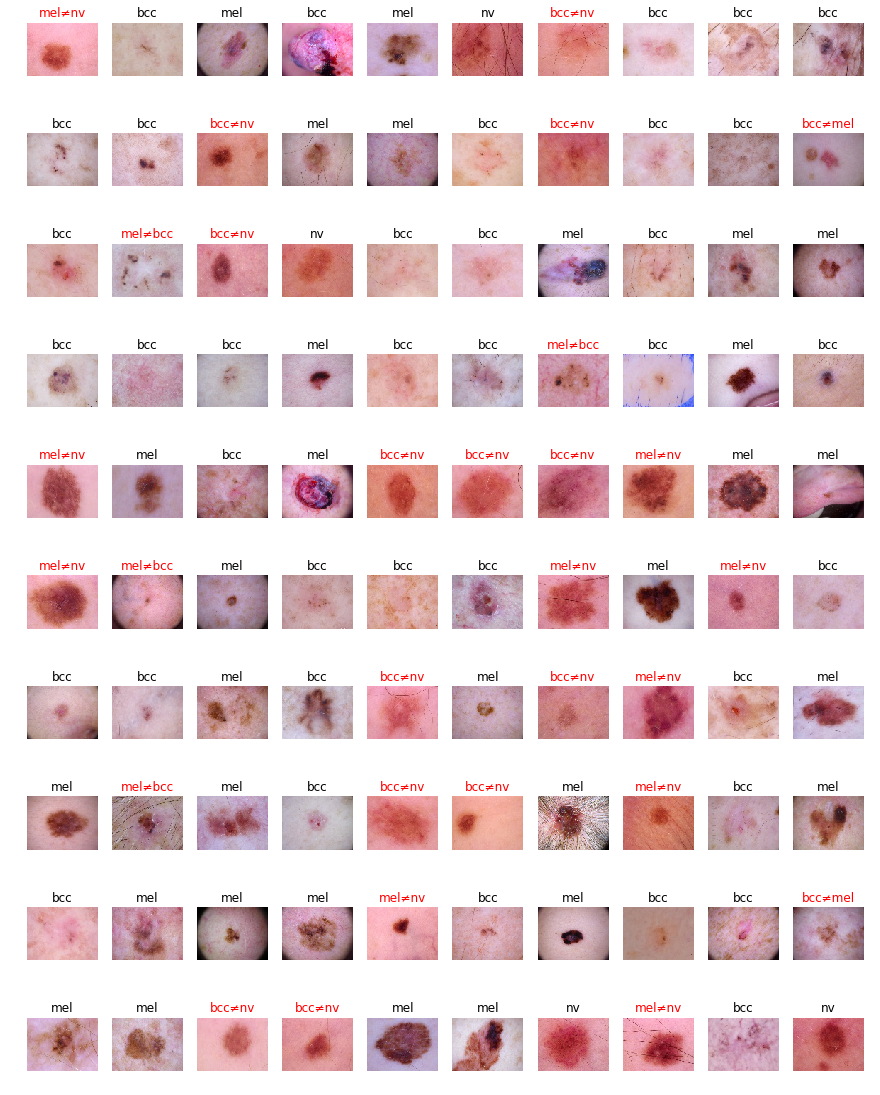

The number of correct answers:  71
The number of mistakes:  29
A correct answer rate:  71.0 %


In [66]:
plt.rcParams['figure.figsize'] = (15.0, 20.0)

nv_cancer_labels = np.array([
    'nv',
    'mel',
    'bcc'
])

right = 0
mistake = 0


index = np.zeros(100)
for i in range(100):
    index[i] += random.randint(0,x_validate.shape[0]-1)

for i in range(100):
    num = int(index[i])
    image = x_validate[num]
    for k in [0,1,2]:
        if y_validate[num][k] == 1:
            ans = k
#     data = image.reshape((1, 45, 60, 3))
    data = x_validate[num].reshape((1, 75, 100, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=64)
#     pred = model.predict(data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    
    
    if bestclass == ans:
        plt.title(nv_cancer_labels[bestclass])
        right += 1
    else:
        plt.title(nv_cancer_labels[bestclass] + '≠' + nv_cancer_labels[ans], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [ ]:
_nv_train, _nv_test = img_array(data_type[0], img_dir, 6705)
# nv_test_mean = np.mean(_nv_test)
# nv_test_std = np.std(_nv_test)
# _nv_test_ = (_nv_test - nv_test_mean)/nv_test_std
_nv_test_ = _nv_test

In [ ]:
index = np.zeros(100)
for i in range(100):
    index[i] += random.randint(0,_nv_test.shape[0]-1)

right = 0
mistake = 0
for i in range(100):
#     num = i
    num = int(index[i])
#     num = 1851 + i
#     num = 3702 + i
    image = _nv_test[num]
#   data = convertSize(image)
#     data = image.reshape((1, 45, 60, 3))
    data = _nv_test_[num].reshape((1, 75, 100, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image*255)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=64)
#     pred = model.predict(data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    
    if  bestclass == 0:
        plt.title(nv_cancer_labels[bestclass])
        right += 1
    else:
        plt.title(nv_cancer_labels[bestclass] + '≠' + nv_cancer_labels[0], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [ ]:
right = 0
mistake = 0

for j in range(100):
    index = np.zeros(100)
    for i in range(100):
        index[i] += random.randint(0,_nv_test.shape[0]-1)

    for i in range(100):
        num = int(index[i])
        data = _nv_test_[num].reshape((1, 75, 100, 3))

        pred = model.predict(data, batch_size=64)
        bestnum  = 0.0
        bestclass = 0
        for n in [0,1,2]:
            if bestnum < pred[0][n]:
                bestnum = pred[0][n]
                bestclass = n

        if  bestclass == 0:
            right += 1
        else:
            mistake += 1

print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [ ]:
index = np.zeros(100)
for i in range(100):
    index[i] += random.randint(0,_nv_test.shape[0])

right = 0
mistake = 0
for i in range(100):
#     num = i
    num = int(index[i])
#     num = 1851 + i
#     num = 3702 + i
    image = _nv_test[num] / 255.0
#   data = convertSize(image)
#     data = image.reshape((1, 45, 60, 3))
    data = _nv_test_[num].reshape((1, 45, 60, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=64)
#     pred = model.predict(data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    
    if  bestclass == 0:
        plt.title(nv_cancer_labels[bestclass])
        right += 1
    else:
        plt.title(nv_cancer_labels[bestclass] + '≠' + nv_cancer_labels[0], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [ ]:
index[86]

In [ ]:
right = 0
mistake = 0

for j in range(100):
    index = np.zeros(100)
    for i in range(100):
        index[i] += random.randint(0,_nv_test.shape[0]-1)

    for i in range(100):
        num = int(index[i])
        data = _nv_test_[num].reshape((1, 45, 60, 3))

        pred = model.predict(data, batch_size=64)
        bestnum  = 0.0
        bestclass = 0
        for n in [0,1,2]:
            if bestnum < pred[0][n]:
                bestnum = pred[0][n]
                bestclass = n

        if  bestclass == 0:
            right += 1
        else:
            mistake += 1

print ("A correct answer rate: ", right/(mistake + right) * 100, '%')